This notebook illustrates how to extract a weak ground truth of healthy and cancer cell bounding boxes from H&E patches. The procedure is essentially identical for IHC images, except the expert annotation is replaced with an automatically derived mask from the DAB channel. This code can be wrapped in a set of for-loops for batch processing.

In [1]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from library_utils import *

First, a stain decomposition is performed:

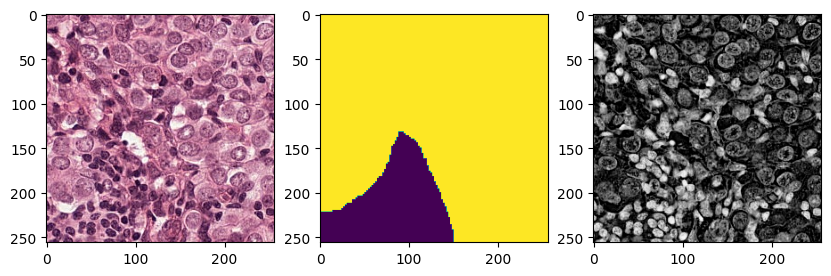

In [2]:
patches_file = 'CAMELYON_HE_patches.h5'
masks_file = 'CAMELYON_HE_masks.h5'

x_images = h5py.File(patches_file, 'r')['x']
y_images = h5py.File(masks_file, 'r')['y']

tile_idx = 0

input_img = x_images[tile_idx]
mask = y_images[tile_idx]

ihc_h, _, _ = decompose_ihc(input_img)
ihc_h_gray = rgb2gray(ihc_h)

fig, axes = plt.subplots(ncols=3, figsize=(10, 5))

axes[0].imshow(input_img)
axes[1].imshow(mask)
axes[2].imshow(ihc_h_gray, cmap='Greys')

Clusters of negative (healthy) cells are identified to avoid detecting positive (cancer) cells in those regions, thereby attenuating false positives. The convex hull of clusters of normal cells is 

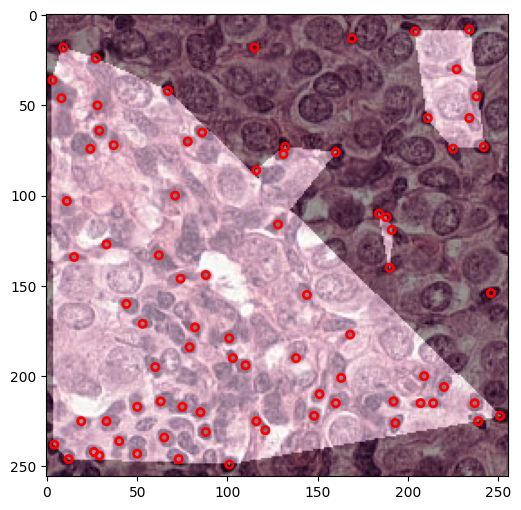

In [3]:
gauss_sigma = 2
min_sigma = 1
max_sigma = 2
threshold = 0.1

normal_blobs = get_cells(ihc_h_gray, gauss_sigma, min_sigma, max_sigma, threshold)
normal_points = normal_blobs[:, :2]  # take coordinates

normal_cell_clusters = find_clusters(normal_points)
cluster_mask = get_cluster_mask(normal_cell_clusters)

mask_patch = np.repeat(255 * cluster_mask[..., None], 3, axis=2).astype('uint8')
patch = addWeighted(input_img, 0.6, mask_patch, 0.4, 0)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(patch)

for blob in normal_blobs:
    y, x, r = map(int, blob)
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

plt.show()

The clusters create an exclusion mask, which is dilated to allow a higher margin of error. This is combined with the expert annotation to form a full exclusion region. Note when processing IHC images, the expert annotation is replaced with the thresholded DAB channel:

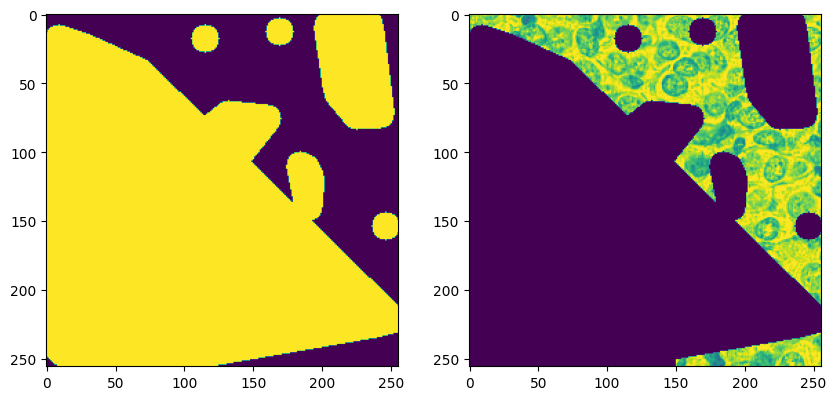

In [4]:
cluster_points = reduce(lambda x, y : x.union(y), normal_cell_clusters)
isolated_points = list(filter(lambda point : not tuple(point)[::-1] in
                              cluster_points, normal_points))

normal_cells = []

for cluster in normal_cell_clusters:
    if len(cluster) < 3:
        for point in cluster:
            isolated_points.append(point[::-1])
    else:
        for point in cluster:
            x, y = map(int, point)  # N.B. X, Y FORMAT BECAUSE OF PIL--SEE ABOVE
            normal_cells.append((y, x))

for point in isolated_points:
    y, x = map(int, point)
    cluster_mask[y, x] = 1

selem = disk(10)
dilated_cluster_mask = dilation(cluster_mask, selem)

full_mask = mask * (1 - dilated_cluster_mask)
masked_input_img = full_mask * ihc_h_gray

fig, axes = plt.subplots(ncols=2, figsize=(10, 6))

axes[0].imshow(dilated_cluster_mask)
axes[1].imshow(masked_input_img)

We now detect the cancer cells with another round of blob detection on the masked image. The bounding boxes are written to a `pandas.DataFrame`:

In [5]:
gauss_sigma = 1
min_sigma = 10
max_sigma = 12
threshold = 0.01

cancer_blobs = get_cells(ihc_h_gray, gauss_sigma, min_sigma, max_sigma, threshold)
cancer_cells = []

for blob in cancer_blobs:

    y, x, r = map(int, blob)
    if full_mask[y, x]:
        cancer_cells.append((y, x))

bbox_data = []
        
crops, bboxes = get_crops_image(input_img, normal_cells)
bboxes = [[patches_file] + [tile_idx] + bbox + [0] for bbox in bboxes]
bbox_data.extend(bboxes)

crops, bboxes = get_crops_image(input_img, cancer_cells)
bboxes = [[patches_file] + [tile_idx] + bbox + [1] for bbox in bboxes]
bbox_data.extend(bboxes)

columns = ['patch_file', 'tile', 'xmin', 'ymin', 'xmax', 'ymax', 'class']
index = np.arange(len(bbox_data))
file_name = '%s.csv' % patches_file.split('.')[0]

df_bboxes = pd.DataFrame(bbox_data, columns=columns, index=index)
df_bboxes.head()

,patch_file,tile,xmin,ymin,xmax,ymax,class
0,CAMELYON_HE_patches.h5,0,203,6,251,54,0
1,CAMELYON_HE_patches.h5,0,201,50,249,98,0
2,CAMELYON_HE_patches.h5,0,187,33,235,81,0
3,CAMELYON_HE_patches.h5,0,61,196,109,244,0
4,CAMELYON_HE_patches.h5,0,38,109,86,157,0


We visualise the result. At train time the bounding boxes can be randomly subsampled and balanced:

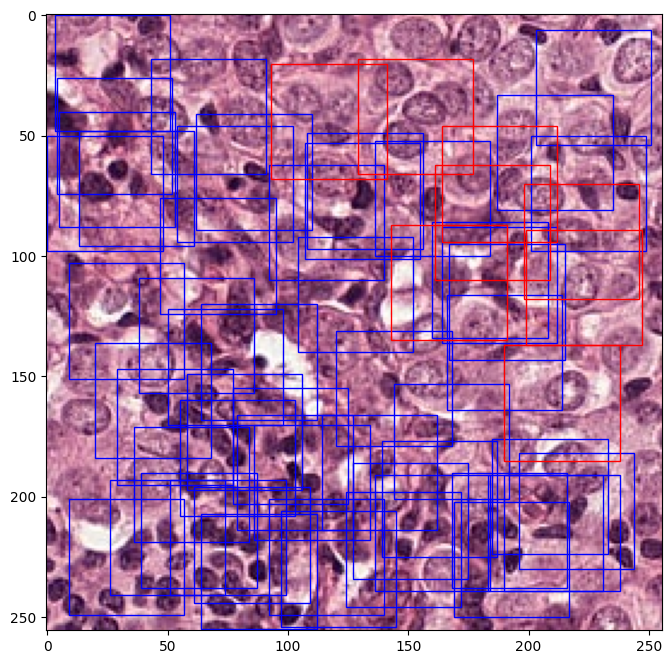

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(input_img)

for i, row in df_bboxes[df_bboxes.tile == tile_idx].iterrows():
    xmin, ymin, xmax, ymax, cls = row[['xmin', 'ymin', 'xmax', 'ymax', 'class']]

    color = 'r' if cls else 'b'
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                             linewidth=1, edgecolor=color, facecolor='none')
    ax.add_patch(rect)